# Skin Disease Detection System Using PyTorch EfficentNetB0

Using Dermnet


## Importing Data & Basic Setup


In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("shubhamgoel27/dermnet")

# print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/skin-cancer9-classesisic


In [5]:
path = "Data/Dermnet"

train_dir = path + "/train"
test_dir = path + "/test"

In [6]:
import torch
import torchvision
from torchvision import transforms
from pathlib import Path
from torch import nn

device = "cpu"

if torch.cuda.is_available():
    device = "cuda"
elif torch.xpu.is_available():
    device = "xpu"
else: device = "cpu"
device

'cpu'

## Transforms, Dataset & Dataloader


In [7]:
from torchvision import transforms

# Data augmentation has shown to reduce overfitting. My aim with these augments is to make the model find patterns V/S rote memorization.

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
])
test_transfrom = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
])

In [10]:
train_dataset = torchvision.datasets.ImageFolder(train_dir,
                                                 transform=train_transform,
                                                 target_transform=None)

test_dataset = torchvision.datasets.ImageFolder(test_dir,
                                                 transform=test_transfrom,
                                                 target_transform=None)

img, label = train_dataset[1][0], train_dataset[1][1]

img.shape

torch.Size([3, 224, 224])

In [11]:
len(train_dataset)

15557

In [12]:
class_names = train_dataset.classes
len(class_names)

23

Text(0.5, 1.0, 'Acne and Rosacea Photos')

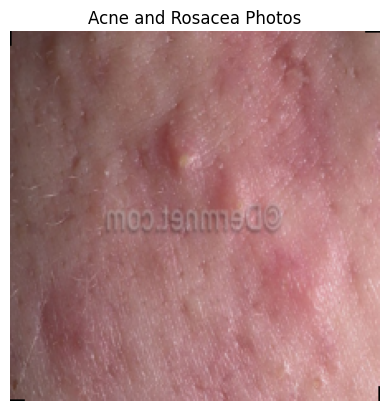

In [13]:
import matplotlib.pyplot as plt

plt.imshow(img.permute(1,2,0))
plt.axis(False)
plt.title(class_names[label])

In [14]:
import os
os.cpu_count()

8

In [15]:
from torch.utils.data import DataLoader

BATCH_SIZE = 50

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=5)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=5)

len(train_dataloader), len(test_dataloader)

(312, 81)

## Combining Both Models (Proposed Architecture)


In [24]:
import torch
import torchvision.models as models
from torch import nn

# Load EfficientNetB0 pretrained model
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

for i, layers in enumerate(model.features.children()):
    if i < 7:
        for param in layers.parameters():
            param.requires_grad = False
        print(f"Froze: {layers}")
    else:
        print(f"Trainable: {layers}")

num_classes = len(class_names)  # Your dataset classes
model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)


Froze: Conv2dNormActivation(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
)
Froze: Sequential(
  (0): MBConv(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): SqueezeExcitation(
        (avgpool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        (activation): SiLU(inplace=True)
        (scale_activation): Sigmoid()
      )
      (2): Conv2dNormActivation(
        (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, 

## Custom Functions For Training & Testing


In [25]:
from tqdm.auto import tqdm

def train_step(model: nn.Module,
               dataloader,
               loss_fn,
               optimizer,
               acc_fn,
               device):

    """
    Function to train our model with clearly set hyperparameters
    """

    train_acc, train_loss = 0,0

    for batch, (X,y) in enumerate(dataloader):
        model.train()
        X, y = X.to(device), y.to(device)
        logits = model(X)

        y=y.to(torch.int64)

        loss = loss_fn(logits, y)
        acc = acc_fn(preds=logits.argmax(dim=1), target=y)

        train_loss += loss.item()
        train_acc += acc

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 9 == 0:
            print(f"Went through {batch} batches")
            print(f"|| Train_Accuracy: {acc:.3f} & Train_Loss: {loss:.3f} ||")

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f"|| Train_Accuracy: {train_acc:.3f} & Train_Loss: {train_loss:.3f} ||")
    print("Training for current epoch completed successfully.")
    return train_acc, train_loss

def test_step(model: nn.Module,
             dataloader,
             loss_fn,
             acc_fn,
             device):
    
    """
    Function to test our model with clearly set hyperparameters
    """

    test_acc, test_loss = 0,0

    for batch, (X,y) in enumerate(dataloader):
        model.eval()
        X, y = X.to(device), y.to(device)
        with torch.inference_mode():
            logits = model(X)

            y=y.to(torch.int64)

            loss = loss_fn(logits, y)
            acc = acc_fn(preds=logits.argmax(dim=1), target=y)

            test_loss += loss.item()
            test_acc += acc

            if batch % 9 == 0:
                print(f"Went through {batch} batches")
                print(f"|| Train_Accuracy: {acc:.3f} & Train_Loss: {loss:.3f} ||")

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    print(f"|| Test_Accuracy: {test_acc:.3f} & Test_Loss: {test_loss:.3f} ||")
    print("Testing for current epoch completed successfully.")
    return test_acc, test_loss

def train(model: nn.Module,
        train_dataloader,
        test_dataloader,
        loss_fn,
        optimizer,
        acc_fn,
        device,
        epochs: int):
    """
    Function to train the model for a specified number of epochs
    """

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    EPOCHS = epochs

    for epoch in tqdm(range(EPOCHS)):
        print(f"\n\nStarting Epoch: {epoch}-----------------------------")
        train_acc, train_loss = train_step(model, train_dataloader, loss_fn, optimizer, acc_fn, device)
        test_acc, test_loss = test_step(model, test_dataloader, loss_fn, acc_fn, device)
        print(f"\nEnding Epoch: {epoch}-----------------------------")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01,
                            momentum=0.9,
                            weight_decay=0.0001)
def acc_fn(target, preds):
  """
  Calculates Accuracy.

  Args:
    target: The real data
    preds: Processed logits from the model
  """
  correct = torch.eq(target, preds).sum().item()
  acc = (correct/len(preds)) * 100
  return acc

## Training Loop


In [29]:
from timeit import default_timer as timer

start = timer()

EPOCHS = 20

model_0_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        acc_fn=acc_fn,
                        device=device,
                        epochs=EPOCHS)

end = timer()

print(f"Training Time: {end-start:.2f} seconds for {EPOCHS} epochs on {device}.")

  0%|          | 0/20 [00:00<?, ?it/s]



Starting Epoch: 0-----------------------------
Went through 0 batches
|| Train_Accuracy: 52.000 & Train_Loss: 1.995 ||
Went through 9 batches
|| Train_Accuracy: 48.000 & Train_Loss: 1.879 ||
Went through 18 batches
|| Train_Accuracy: 46.000 & Train_Loss: 1.986 ||
Went through 27 batches
|| Train_Accuracy: 36.000 & Train_Loss: 2.012 ||
Went through 36 batches
|| Train_Accuracy: 34.000 & Train_Loss: 2.352 ||
Went through 45 batches
|| Train_Accuracy: 34.000 & Train_Loss: 2.176 ||
Went through 54 batches
|| Train_Accuracy: 30.000 & Train_Loss: 2.343 ||
Went through 63 batches
|| Train_Accuracy: 42.000 & Train_Loss: 2.112 ||
Went through 72 batches
|| Train_Accuracy: 34.000 & Train_Loss: 2.310 ||
Went through 81 batches
|| Train_Accuracy: 36.000 & Train_Loss: 2.146 ||
Went through 90 batches
|| Train_Accuracy: 38.000 & Train_Loss: 2.028 ||
Went through 99 batches
|| Train_Accuracy: 38.000 & Train_Loss: 1.836 ||
Went through 108 batches
|| Train_Accuracy: 34.000 & Train_Loss: 2.304 ||
Wen

  5%|▌         | 1/20 [15:18<4:50:58, 918.85s/it]

|| Test_Accuracy: 41.630 & Test_Loss: 1.985 ||
Testing for current epoch completed successfully.

Ending Epoch: 0-----------------------------


Starting Epoch: 1-----------------------------
Went through 0 batches
|| Train_Accuracy: 40.000 & Train_Loss: 1.840 ||
Went through 9 batches
|| Train_Accuracy: 40.000 & Train_Loss: 1.731 ||
Went through 18 batches
|| Train_Accuracy: 42.000 & Train_Loss: 1.879 ||
Went through 27 batches
|| Train_Accuracy: 42.000 & Train_Loss: 1.822 ||
Went through 36 batches
|| Train_Accuracy: 38.000 & Train_Loss: 1.868 ||
Went through 45 batches
|| Train_Accuracy: 44.000 & Train_Loss: 1.856 ||
Went through 54 batches
|| Train_Accuracy: 46.000 & Train_Loss: 1.865 ||
Went through 63 batches
|| Train_Accuracy: 46.000 & Train_Loss: 1.959 ||
Went through 72 batches
|| Train_Accuracy: 38.000 & Train_Loss: 1.892 ||
Went through 81 batches
|| Train_Accuracy: 44.000 & Train_Loss: 1.835 ||
Went through 90 batches
|| Train_Accuracy: 36.000 & Train_Loss: 1.995 ||
Went th

 10%|█         | 2/20 [30:46<4:37:10, 923.90s/it]

|| Test_Accuracy: 44.938 & Test_Loss: 1.898 ||
Testing for current epoch completed successfully.

Ending Epoch: 1-----------------------------


Starting Epoch: 2-----------------------------
Went through 0 batches
|| Train_Accuracy: 70.000 & Train_Loss: 1.273 ||
Went through 9 batches
|| Train_Accuracy: 44.000 & Train_Loss: 1.911 ||
Went through 18 batches
|| Train_Accuracy: 50.000 & Train_Loss: 1.846 ||
Went through 27 batches
|| Train_Accuracy: 52.000 & Train_Loss: 1.680 ||
Went through 36 batches
|| Train_Accuracy: 46.000 & Train_Loss: 1.818 ||
Went through 45 batches
|| Train_Accuracy: 38.000 & Train_Loss: 1.693 ||
Went through 54 batches
|| Train_Accuracy: 52.000 & Train_Loss: 1.575 ||
Went through 63 batches
|| Train_Accuracy: 42.000 & Train_Loss: 1.816 ||
Went through 72 batches
|| Train_Accuracy: 50.000 & Train_Loss: 1.824 ||
Went through 81 batches
|| Train_Accuracy: 32.000 & Train_Loss: 2.207 ||
Went through 90 batches
|| Train_Accuracy: 42.000 & Train_Loss: 1.734 ||
Went th

 15%|█▌        | 3/20 [48:53<4:42:52, 998.40s/it]

|| Test_Accuracy: 47.160 & Test_Loss: 1.852 ||
Testing for current epoch completed successfully.

Ending Epoch: 2-----------------------------


Starting Epoch: 3-----------------------------
Went through 0 batches
|| Train_Accuracy: 62.000 & Train_Loss: 1.302 ||
Went through 9 batches
|| Train_Accuracy: 58.000 & Train_Loss: 1.481 ||
Went through 18 batches
|| Train_Accuracy: 56.000 & Train_Loss: 1.500 ||
Went through 27 batches
|| Train_Accuracy: 56.000 & Train_Loss: 1.406 ||
Went through 36 batches
|| Train_Accuracy: 50.000 & Train_Loss: 1.554 ||
Went through 45 batches
|| Train_Accuracy: 58.000 & Train_Loss: 1.444 ||
Went through 54 batches
|| Train_Accuracy: 56.000 & Train_Loss: 1.389 ||
Went through 63 batches
|| Train_Accuracy: 62.000 & Train_Loss: 1.460 ||
Went through 72 batches
|| Train_Accuracy: 46.000 & Train_Loss: 1.641 ||
Went through 81 batches
|| Train_Accuracy: 52.000 & Train_Loss: 1.621 ||
Went through 90 batches
|| Train_Accuracy: 50.000 & Train_Loss: 1.670 ||
Went th

 20%|██        | 4/20 [1:05:57<4:28:55, 1008.47s/it]

|| Test_Accuracy: 48.691 & Test_Loss: 1.773 ||
Testing for current epoch completed successfully.

Ending Epoch: 3-----------------------------


Starting Epoch: 4-----------------------------
Went through 0 batches
|| Train_Accuracy: 58.000 & Train_Loss: 1.405 ||
Went through 9 batches
|| Train_Accuracy: 56.000 & Train_Loss: 1.330 ||
Went through 18 batches
|| Train_Accuracy: 58.000 & Train_Loss: 1.423 ||
Went through 27 batches
|| Train_Accuracy: 52.000 & Train_Loss: 1.743 ||
Went through 36 batches
|| Train_Accuracy: 54.000 & Train_Loss: 1.562 ||
Went through 45 batches
|| Train_Accuracy: 58.000 & Train_Loss: 1.244 ||
Went through 54 batches
|| Train_Accuracy: 66.000 & Train_Loss: 1.275 ||
Went through 63 batches
|| Train_Accuracy: 52.000 & Train_Loss: 1.646 ||
Went through 72 batches
|| Train_Accuracy: 54.000 & Train_Loss: 1.534 ||
Went through 81 batches
|| Train_Accuracy: 72.000 & Train_Loss: 1.260 ||
Went through 90 batches
|| Train_Accuracy: 56.000 & Train_Loss: 1.449 ||
Went th

 25%|██▌       | 5/20 [1:22:53<4:12:47, 1011.14s/it]

|| Test_Accuracy: 48.617 & Test_Loss: 1.778 ||
Testing for current epoch completed successfully.

Ending Epoch: 4-----------------------------


Starting Epoch: 5-----------------------------
Went through 0 batches
|| Train_Accuracy: 68.000 & Train_Loss: 1.128 ||
Went through 9 batches
|| Train_Accuracy: 70.000 & Train_Loss: 0.976 ||
Went through 18 batches
|| Train_Accuracy: 46.000 & Train_Loss: 1.529 ||
Went through 27 batches
|| Train_Accuracy: 54.000 & Train_Loss: 1.290 ||
Went through 36 batches
|| Train_Accuracy: 58.000 & Train_Loss: 1.477 ||
Went through 45 batches
|| Train_Accuracy: 56.000 & Train_Loss: 1.341 ||
Went through 54 batches
|| Train_Accuracy: 46.000 & Train_Loss: 1.525 ||
Went through 63 batches
|| Train_Accuracy: 46.000 & Train_Loss: 1.560 ||
Went through 72 batches
|| Train_Accuracy: 64.000 & Train_Loss: 1.317 ||
Went through 81 batches
|| Train_Accuracy: 54.000 & Train_Loss: 1.480 ||
Went through 90 batches
|| Train_Accuracy: 48.000 & Train_Loss: 1.589 ||
Went th

 25%|██▌       | 5/20 [1:38:07<4:54:23, 1177.58s/it]


KeyboardInterrupt: 

In [30]:
model_0_results

{'train_loss': [2.412994663684796],
 'train_acc': [29.55860805860806],
 'test_loss': [2.1333931446259404],
 'test_acc': [37.28395061728395]}